# Machine Learning Project: Medical Insurance Cost Prediction
Objective: Developing a machine learning model to predict medical insurance costs based on individual features such as age, BMI, and smoking status.

# Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [7]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# Exploratory Data Analysis (EDA)

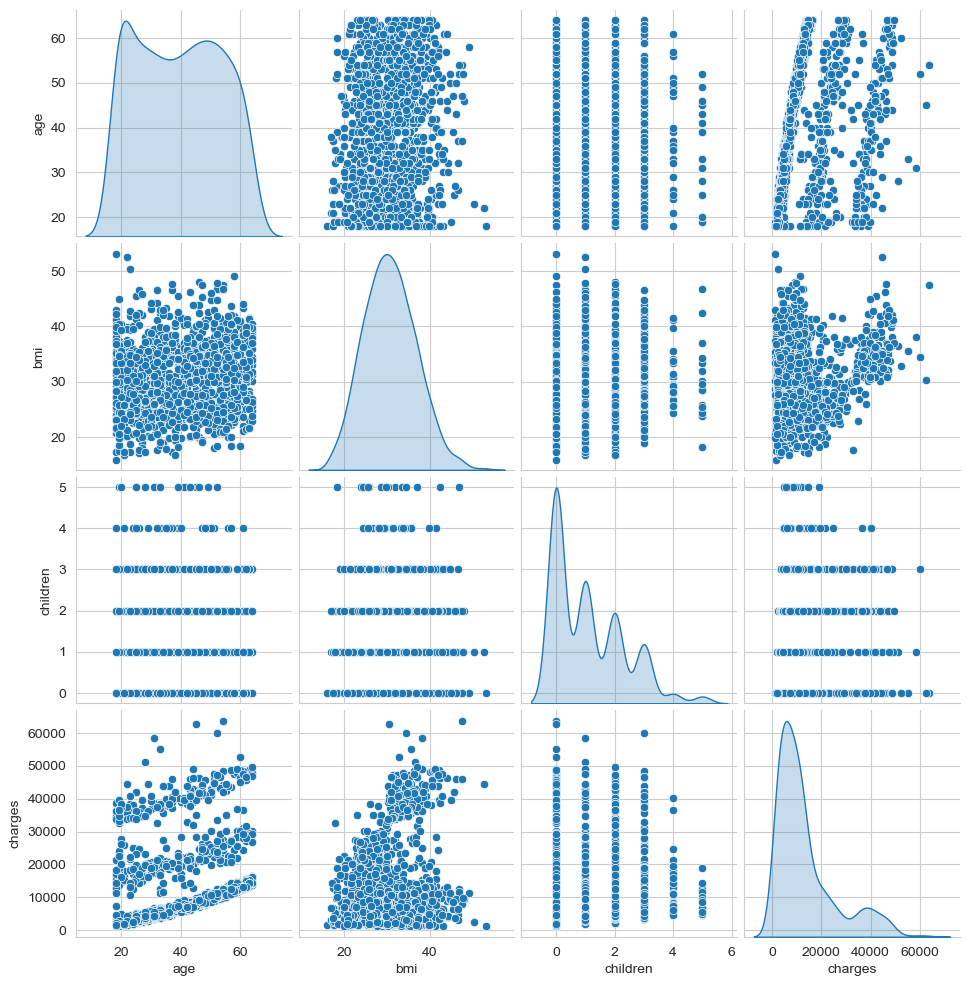

In [8]:
sns.pairplot(df, diag_kind='kde')
plt.show()

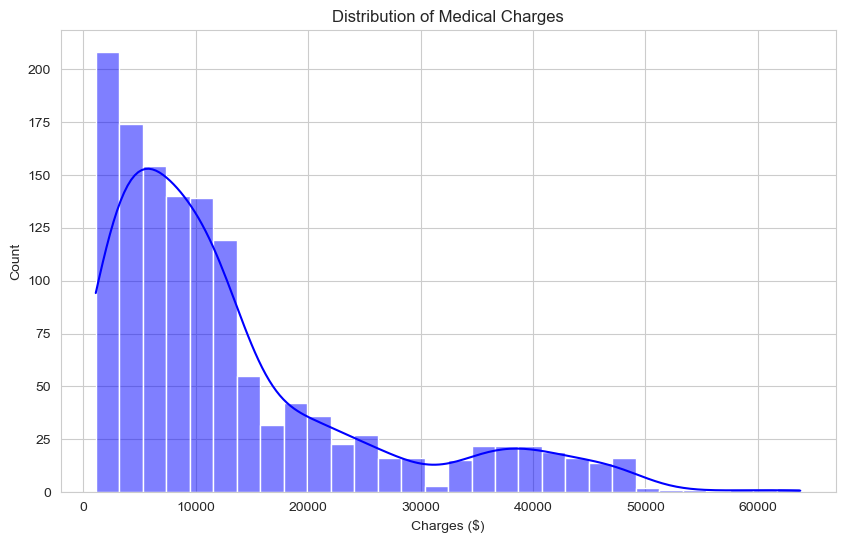

Skewness of Charges: 1.52


In [9]:
# 2.1 Distribution of Charges (Target)
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribution of Medical Charges')
plt.xlabel('Charges ($)')
plt.show()
print(f"Skewness of Charges: {df['charges'].skew():.2f}")

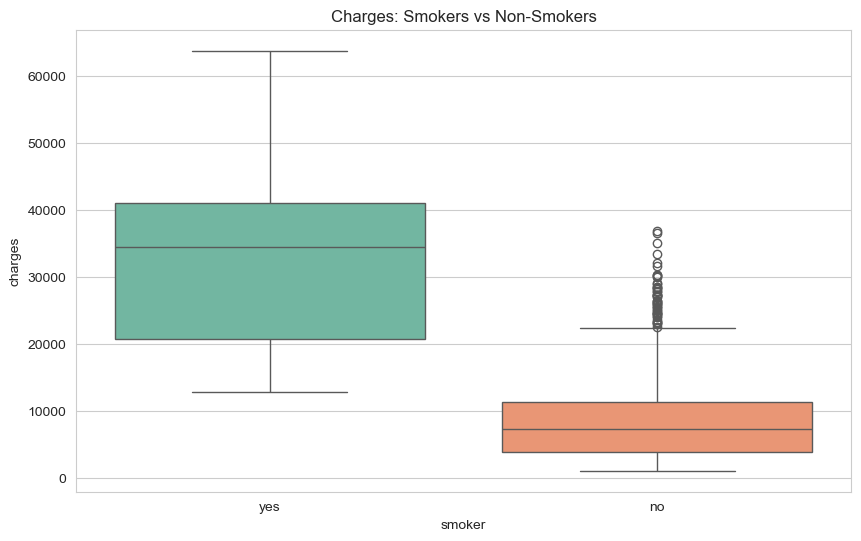

In [10]:
# 2.2 Smoker vs Charges
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=df, palette='Set2')
plt.title('Charges: Smokers vs Non-Smokers')
plt.show()

<Figure size 1000x600 with 0 Axes>

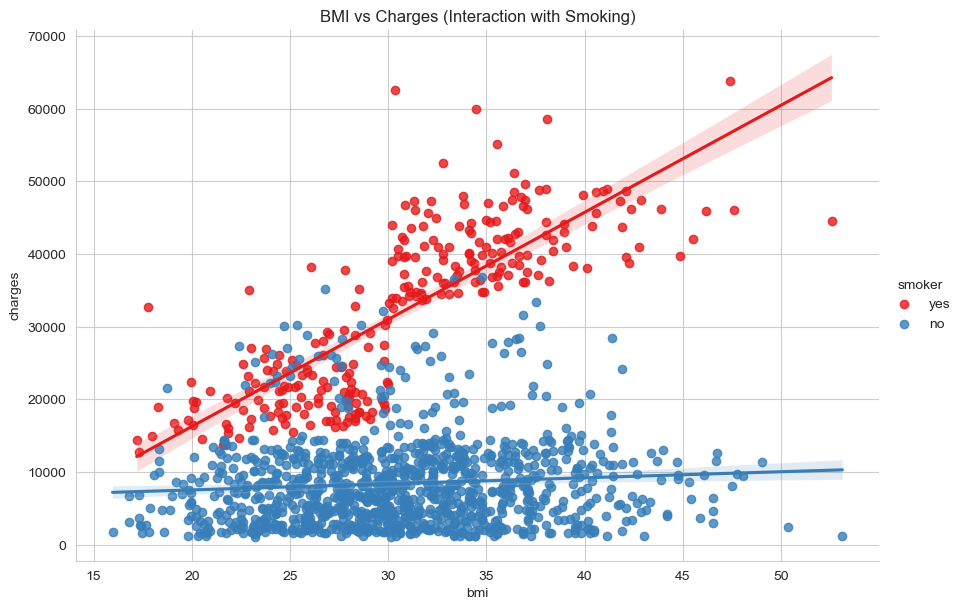

In [11]:
# 2.3 The Interaction Effect (BMI * Smoker)
# This reveals that high BMI only drastically increases cost if you smoke.
plt.figure(figsize=(10, 6))
sns.lmplot(x='bmi', y='charges', hue='smoker', data=df, height=6, aspect=1.5, palette='Set1')
plt.title('BMI vs Charges (Interaction with Smoking)')
plt.show()

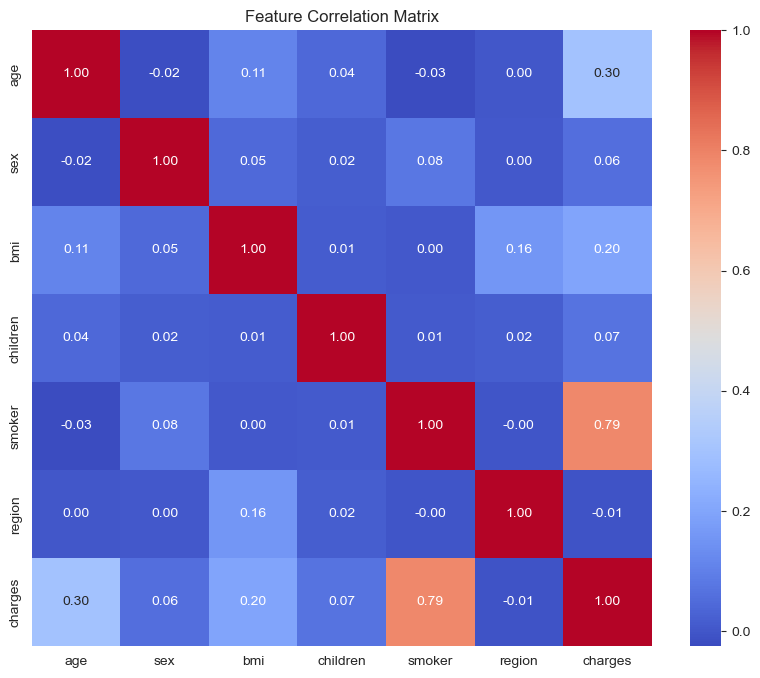

In [12]:
# 2.4 Correlation Heatmap
# We temporarily encode categoricals just to see the heatmap
df_corr = df.copy()
for col in ['sex', 'smoker', 'region']:
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col])

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Data Preprocessing

In [13]:
# 1. Label Encoding for Binary Variables
# Sex: female -> 0, male -> 1 (alphabetical)
# Smoker: no -> 0, yes -> 1
le_sex = LabelEncoder()
le_smoker = LabelEncoder()

df['sex'] = le_sex.fit_transform(df['sex'])
df['smoker'] = le_smoker.fit_transform(df['smoker'])

In [14]:
# 2. One-Hot Encoding for Nominal Variable (Region)
# drop_first=True removes the first column to prevent multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# Display processed dataframe columns to verify
print("Columns after encoding:")
print(df.columns.tolist())
display(df.head())

Columns after encoding:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


# Train-Test Split & Scaling

In [15]:
# Define Features (X) and Target (y)
X = df.drop('charges', axis=1)
y = df['charges']

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
# We fit the scaler on Training data only, then transform both Train and Test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training shape: {X_train_scaled.shape}")
print(f"Testing shape: {X_test_scaled.shape}")

Training shape: (1070, 8)
Testing shape: (268, 8)


# Model Training (Multi-Model Comparison)

In [16]:
# Model 1: Linear Regression (Baseline)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Model 2: Random Forest (Ensemble Bagging)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Model 3: Gradient Boosting (Ensemble Boosting)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

# Model 4: Polynomial Regression (Degree 2)
# Captures curves in the data (like the BMI curve)
poly = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly.fit(X_train_scaled, y_train)
y_pred_poly = poly.predict(X_test_scaled)

print("All models trained successfully.")

All models trained successfully.


# Hyperparameter Tuning (Optimization)

In [17]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],       # Number of trees
    'learning_rate': [0.01, 0.1],     # Contribution of each tree
    'max_depth': [3, 4]               # Maximum depth of trees
}

print("Starting Grid Search... this may take a moment.")
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

Starting Grid Search... this may take a moment.


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [18]:
# Capture the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print("\nBest Parameters:", grid_search.best_params_)
print(f"Best CV Score (R2): {grid_search.best_score_:.4f}")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV Score (R2): 0.8409


# Model Evaluation

,Model,R2 Score,RMSE,MAE
2,Gradient Boosting (Default),0.878862,4336.649172,2457.193349
4,Gradient Boosting (Tuned),0.878862,4336.649172,2457.193349
3,Polynomial Regression,0.865924,4562.363604,2801.429943
1,Random Forest,0.865526,4569.132510,2545.158651
0,Linear Regression,0.783593,5796.284659,4181.194474


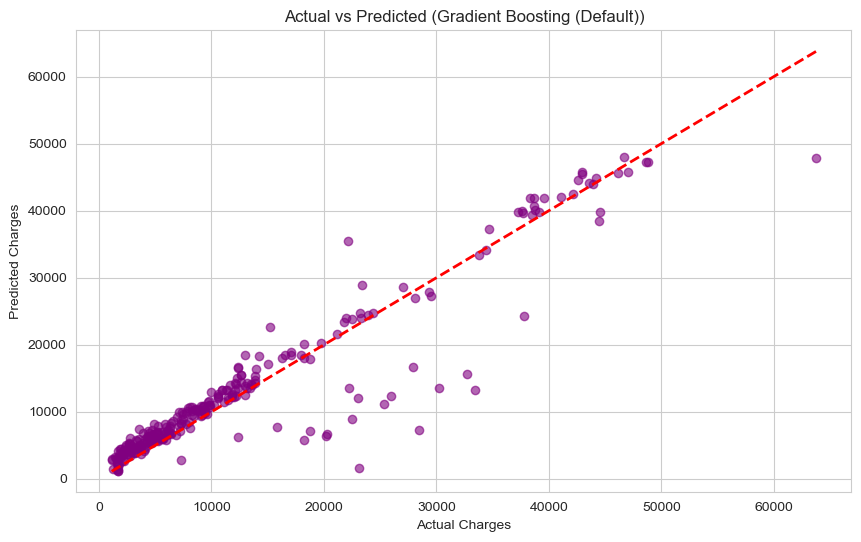

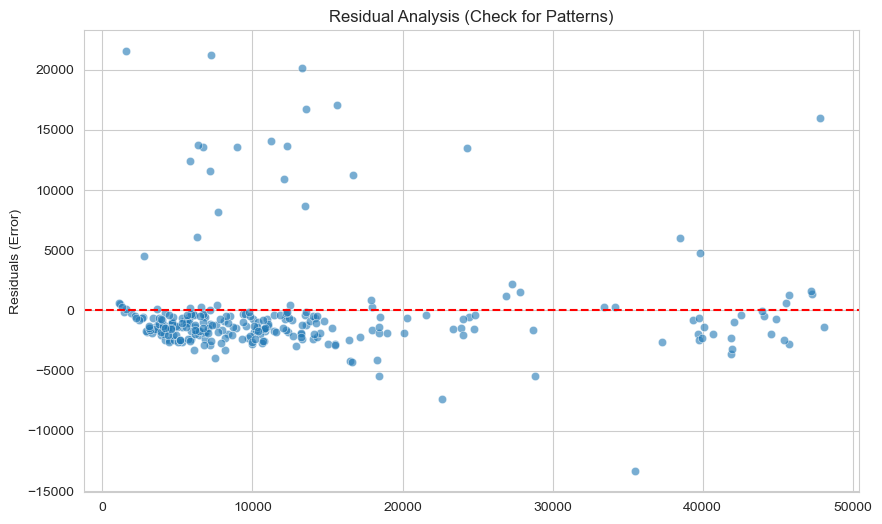

In [19]:
results = {'Model': [], 'R2 Score': [], 'RMSE': [], 'MAE': []}

def log_result(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    results['Model'].append(name)
    results['R2 Score'].append(r2)
    results['RMSE'].append(rmse)
    results['MAE'].append(mae)

# Log all results
log_result("Linear Regression", y_test, y_pred_lr)
log_result("Random Forest", y_test, y_pred_rf)
log_result("Gradient Boosting (Default)", y_test, y_pred_gbr)
log_result("Polynomial Regression", y_test, y_pred_poly)
log_result("Gradient Boosting (Tuned)", y_test, y_pred_best)

# Display Leaderboard
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
display(results_df)

# Visual: Actual vs Predicted (for the Best Model)
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title(f'Actual vs Predicted ({results_df.iloc[0]["Model"]})')
plt.show()

# Visual: Residual Plot
residuals = y_test - y_pred_best
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis (Check for Patterns)')
plt.ylabel('Residuals (Error)')
plt.show()

# Feature Importance

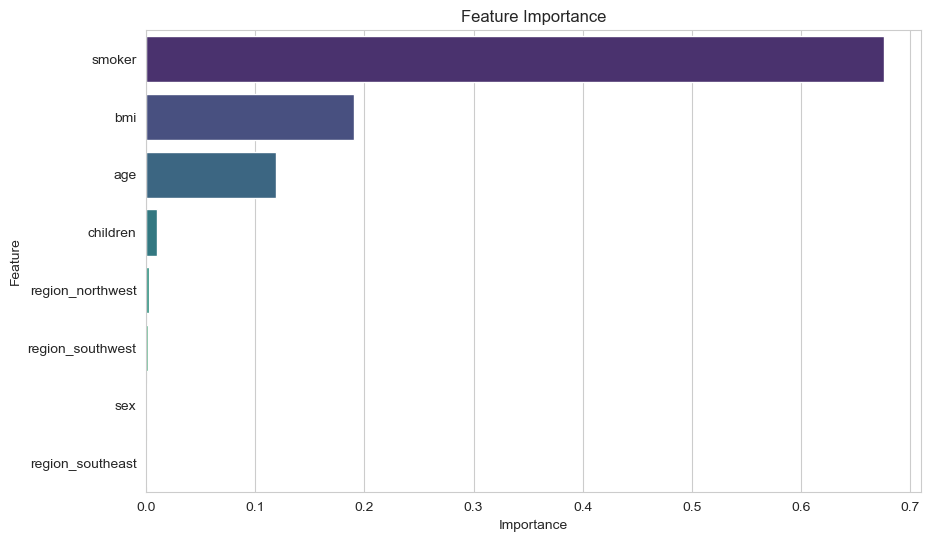

In [20]:
# We extract feature importance from the Best Model (Gradient Boosting)
importances = best_model.feature_importances_
feature_names = X.columns

# Create DataFrame
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

# Prediction System (Inference)

In [21]:
def predict_insurance_cost(age, sex, bmi, children, smoker, region):
    """
    Predicts insurance cost based on input features.
    """
    # 1. Encode Sex and Smoker using the mapping logic
    # Sex: male=1, female=0
    sex_enc = 1 if sex.lower() == 'male' else 0
    
    # Smoker: yes=1, no=0
    smoker_enc = 1 if smoker.lower() == 'yes' else 0
    
    # 2. Handle Region (One-Hot Encoding)
    # The columns in X are: [age, sex, bmi, children, smoker, region_northwest, region_southeast, region_southwest]
    # 'northeast' was dropped during training, so if region is northeast, all 3 region cols are 0
    region_nw = 1 if region.lower() == 'northwest' else 0
    region_se = 1 if region.lower() == 'southeast' else 0
    region_sw = 1 if region.lower() == 'southwest' else 0
    
    # Create array with correct feature order
    input_data = pd.DataFrame({
        'age': [age],
        'sex': [sex_enc],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker_enc],
        'region_northwest': [region_nw],
        'region_southeast': [region_se],
        'region_southwest': [region_sw]
    })
    
    # 3. Scale the input using the pre-fitted scaler
    input_scaled = scaler.transform(input_data)
    
    # 4. Predict
    prediction = best_model.predict(input_scaled)
    return prediction[0]

# --- Test Cases ---
print("--- Prediction Test Cases ---")

# Case 1: High Risk (Smoker, High BMI)
cost1 = predict_insurance_cost(age=40, sex='male', bmi=35, children=2, smoker='yes', region='southeast')
print(f"Case 1 (Smoker, High BMI): ${cost1:,.2f}")

# Case 2: Low Risk (Non-Smoker, Normal BMI)
cost2 = predict_insurance_cost(age=40, sex='male', bmi=24, children=2, smoker='no', region='southeast')
print(f"Case 2 (Non-Smoker, Low BMI): ${cost2:,.2f}")

--- Prediction Test Cases ---
Case 1 (Smoker, High BMI): $40,807.88
Case 2 (Non-Smoker, Low BMI): $7,826.85
